## Active compound classification

Predictions surrounding IC50 values don't display the full potential of a therapeutic. There are many other factors that contributes to a drug's success. One key feature in this dataset that impacts pharmacodynamics and pharmacokinetics is the LogP of a compound.

LogP is a measure of lipophilicity, and is defined by the ratio at equilbrium of the concentration of a compound between two phases, an organic(oil) and an aqueous(water) phase. This value is important to pharmacodynamics, as it is an effective indicator of drug administration, metabolism, and trafficking. Drugs with a higher LogP are more soluble in oil, while those with a lower (or even negative) LogP are more soluble in water. Of all the features in this dataset, IC50 and XLogP are the two most important.

These two values are of primary importance due to how they influence drug dosages (pIC50) and routes of administration (XLogP). Typically, compounds with pIC50s higher than 6 are considered active, as they have activity in this sub-micromolar range. Ideally, for dosing reasons, pIC50s higher than 9 are considered exceptionally potent inhibitors of drug targets. Furthermore, for the purposes of this dataset, XLogP values of greater than 1 will be considered 'active'/ideal. Generally, we wish for drugs to be more lipophilic so they can traverse membranes in cells which are typically lipophilic. 

For this section, it is to be determined if compound activity can be predicted without pIC50 or XLogP features. If possible, it would save tremendous resources for drug screening.

In [1]:
#import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
import pubchempy as pcp

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, log_loss
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor


In [3]:
df2 = pd.read_csv('df2.csv')
df2.head()

,XLogP,TPSA,Complexity,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,AtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,5.6,121.0,559.0,1.0,6.0,6.0,30.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121
1,4.9,126.0,670.0,1.0,9.0,6.0,33.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1.000000
2,6.3,175.0,627.0,1.0,8.0,7.0,32.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041393
3,4.4,162.0,554.0,1.0,8.0,6.0,29.0,0.0,0.0,0.0,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128
4,4.4,106.0,529.0,1.0,6.0,6.0,29.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091


In [4]:
#generate labels for active compounds based upon above criteria, where 1= active and 0=not active
labels = []
for i,j in zip(df2['pIC50'], df2['XLogP']):
    if i>=0 and j>=1:
        labels.append(1)
    else:
        labels.append(0)
        
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


In [5]:
df3 = df2.copy()

In [6]:
#append labels to dataframe

df3['labels'] = labels
df3.head()

,XLogP,TPSA,Complexity,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,AtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,...,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50,labels
0,5.6,121.0,559.0,1.0,6.0,6.0,30.0,0.0,0.0,0.0,...,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121,0
1,4.9,126.0,670.0,1.0,9.0,6.0,33.0,0.0,0.0,0.0,...,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1.000000,0
2,6.3,175.0,627.0,1.0,8.0,7.0,32.0,0.0,0.0,0.0,...,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041393,0
3,4.4,162.0,554.0,1.0,8.0,6.0,29.0,0.0,0.0,0.0,...,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128,0
4,4.4,106.0,529.0,1.0,6.0,6.0,29.0,0.0,0.0,0.0,...,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091,0


## Classifier algorithms to predict drug activity 

### Logistic Regression

In [12]:
todrop3 =['XLogP', 'pIC50', 'YStericQuadrupole3D', 'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'Volume3D', 'TPSA',
        'Complexity', 'FeatureDonorCount3D']

y3 = df3[['labels']]
X3 = df3.drop(todrop3, axis=1)

In [13]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X3, y3, test_size=0.3, random_state=265)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

scaler2 = StandardScaler()

X_train_scaled2 = scaler2.fit_transform(X_train2)
X_test_scaled2 = scaler2.transform(X_test2)

logreg = LogisticRegression(random_state=0)
logreg.fit(X_train_scaled2, y_train2.values.ravel()) #adding .values.ravel() to y coverts from col vector to 1d array
y_pred_proba = logreg.predict_proba(X_test_scaled2)
print("Logistic Regression Log loss: ", log_loss(y_test2, y_pred_proba))

Logistic Regression Log loss:  0.024678678248549562


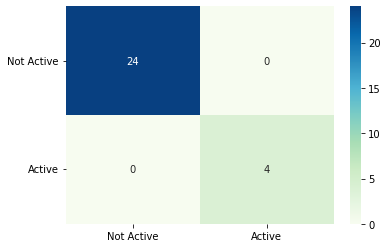

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = logreg.predict(X_test_scaled2)

cm = confusion_matrix(y_test2, y_pred)

sns.heatmap(cm, annot=True, cmap='GnBu', fmt='.4g', xticklabels=['Not Active', 'Active'], 
                       yticklabels=['Not Active', 'Active']), plt.yticks(rotation=0)

plt.show()

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00         4

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



### Insight
A basic Logistic Regression model generated accurate predictions for activity. Of the active compounds in the dataset, can we find any structural trends?

In [18]:
df = pd.read_csv('DDH Data with Properties.csv', sep=",", header=0)
dfs = df.loc[df['pIC50'] != 'BLINDED'].dropna(axis=0, inplace=False)

dfs.head()

,CID,SMILES,MolecularFormula,MolecularWeight,InChI,InChIKey,IUPACName,XLogP,ExactMass,MonoisotopicMass,...,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50
0,2744814,ClC1=CC(NC(=O)CSC2=NC=CC(=N2)C2=CSC(=N2)C2=CC=...,C21H14Cl2N4OS2,473.4,InChI=1S/C21H14Cl2N4OS2/c22-14-8-15(23)10-16(9...,LILOEJREEQFTPM-UHFFFAOYSA-N,"N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thia...",5.6,471.998609,471.998609,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255
1,2821293,CN1N=C(C=C1C(F)(F)F)C1=CC=C(S1)C1=CC=NC(SCC(=O...,C21H15ClF3N5OS2,510.0,"InChI=1S/C21H15ClF3N5OS2/c1-30-18(21(23,24)25)...",AWQBIBTZJKFLEW-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[5-[1-methyl-5-(triflu...,4.9,509.035865,509.035865,...,3.0,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1
2,2820912,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,WRXXISITJDZVCL-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.013024,518.013024,...,3.0,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685
4,2744846,CC1=NC(=CS1)C1=NC(=CS1)C1=NC(SCC(=O)NC2=CC=C(C...,C19H14ClN5OS3,460.0,InChI=1S/C19H14ClN5OS3/c1-11-22-16(9-27-11)18-...,JEZYTEDGOJCVQS-UHFFFAOYSA-N,"N-(4-chlorophenyl)-2-[4-[2-(2-methyl-1,3-thiaz...",4.4,459.004901,459.004901,...,4.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036
5,2745617,ClC1=CC=C(NC(=O)CSC2=NC=CC(=N2)C2=CC(=NO2)C2=C...,C21H15ClN4O2S,422.9,InChI=1S/C21H15ClN4O2S/c22-15-6-8-16(9-7-15)24...,TUBDEXWKZSAMKH-UHFFFAOYSA-N,"N-(4-chlorophenyl)-2-[4-(3-phenyl-1,2-oxazol-5...",4.4,422.060425,422.060425,...,3.0,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259


In [19]:
dfs['labels']=labels
dfs.head()

,CID,SMILES,MolecularFormula,MolecularWeight,InChI,InChIKey,IUPACName,XLogP,ExactMass,MonoisotopicMass,...,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50,labels
0,2744814,ClC1=CC(NC(=O)CSC2=NC=CC(=N2)C2=CSC(=N2)C2=CC=...,C21H14Cl2N4OS2,473.4,InChI=1S/C21H14Cl2N4OS2/c22-14-8-15(23)10-16(9...,LILOEJREEQFTPM-UHFFFAOYSA-N,"N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thia...",5.6,471.998609,471.998609,...,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-0.477121255,0
1,2821293,CN1N=C(C=C1C(F)(F)F)C1=CC=C(S1)C1=CC=NC(SCC(=O...,C21H15ClF3N5OS2,510.0,"InChI=1S/C21H15ClF3N5OS2/c1-30-18(21(23,24)25)...",AWQBIBTZJKFLEW-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[5-[1-methyl-5-(triflu...,4.9,509.035865,509.035865,...,1.0,0.0,1.0,4.0,0.0,1.2,8.0,10.0,-1,0
2,2820912,CSC1=C(C(C)=C(S1)C1=NC(C)=CS1)C1=CC=NC(SCC(=O)...,C22H19ClN4OS4,519.1,InChI=1S/C22H19ClN4OS4/c1-12-10-30-20(25-12)19...,WRXXISITJDZVCL-UHFFFAOYSA-N,N-(4-chlorophenyl)-2-[4-[4-methyl-2-methylsulf...,6.3,518.013024,518.013024,...,1.0,0.0,1.0,4.0,1.0,1.0,8.0,10.0,-1.041392685,0
4,2744846,CC1=NC(=CS1)C1=NC(=CS1)C1=NC(SCC(=O)NC2=CC=C(C...,C19H14ClN5OS3,460.0,InChI=1S/C19H14ClN5OS3/c1-11-22-16(9-27-11)18-...,JEZYTEDGOJCVQS-UHFFFAOYSA-N,"N-(4-chlorophenyl)-2-[4-[2-(2-methyl-1,3-thiaz...",4.4,459.004901,459.004901,...,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.146128036,0
5,2745617,ClC1=CC=C(NC(=O)CSC2=NC=CC(=N2)C2=CC(=NO2)C2=C...,C21H15ClN4O2S,422.9,InChI=1S/C21H15ClN4O2S/c22-15-6-8-16(9-7-15)24...,TUBDEXWKZSAMKH-UHFFFAOYSA-N,"N-(4-chlorophenyl)-2-[4-(3-phenyl-1,2-oxazol-5...",4.4,422.060425,422.060425,...,1.0,0.0,1.0,4.0,0.0,1.0,7.0,10.0,-1.176091259,0


In [20]:
active=dfs.loc[dfs['labels']==1]

active.head(14)

,CID,SMILES,MolecularFormula,MolecularWeight,InChI,InChIKey,IUPACName,XLogP,ExactMass,MonoisotopicMass,...,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D,pIC50,labels
34,2799606,CC1=C(Cl)C=C(Cl)C(=C1)S(=O)(=O)C1=C(C=C(C=C1[N...,C14H7Cl2F3N2O6S,459.20,InChI=1S/C14H7Cl2F3N2O6S/c1-6-2-12(9(16)5-8(6)...,INAZPZCJNPPHGV-UHFFFAOYSA-N,"1,5-dichloro-2-[2,6-dinitro-4-(trifluoromethyl...",4.9,457.935397,457.935397,...,0.0,2.0,0.0,2.0,0.0,0.8,5.0,4.0,0.522878745,1
35,2774892,ClC(Cl)=C(Cl)C(=O)OC1=CC=C(C=C1)S(=O)(=O)C1=CC...,C18H8Cl6O6S,565.00,InChI=1S/C18H8Cl6O6S/c19-13(15(21)22)17(25)29-...,HXYPMMAPDRFFTM-UHFFFAOYSA-N,"[4-[4-(2,3,3-trichloroprop-2-enoyloxy)phenyl]s...",7.3,563.814325,561.817275,...,0.0,0.0,0.0,2.0,0.0,1.0,8.0,10.0,0.045757491,1
55,16203797,ClC1=CC=C(C=C1)C1=CC=C(O1)C(=O)OC1=CN=CC(Cl)=C1,C16H9Cl2NO3,334.10,InChI=1S/C16H9Cl2NO3/c17-11-3-1-10(2-4-11)14-5...,UICFGOSRHHZBHZ-UHFFFAOYSA-N,(5-chloropyridin-3-yl) 5-(4-chlorophenyl)furan...,4.6,332.995948,332.995948,...,0.0,0.0,0.0,3.0,0.0,0.6,4.0,10.0,1.200659451,1
56,16204418,[O-][N+](=O)C1=CC=C(C=C1)C1=CC=C(O1)C(=O)OC1=C...,C16H9ClN2O5,344.70,InChI=1S/C16H9ClN2O5/c17-11-7-13(9-18-8-11)23-...,KVPGYJGIPXOKGJ-UHFFFAOYSA-N,(5-chloropyridin-3-yl) 5-(4-nitrophenyl)furan-...,3.8,344.019999,344.019999,...,0.0,1.0,0.0,3.0,0.0,0.8,5.0,10.0,1.22184875,1
58,16204417,[O-][N+](=O)C1=C(C=CC=C1)C1=CC=C(O1)C(=O)OC1=C...,C16H9ClN2O5,344.70,InChI=1S/C16H9ClN2O5/c17-10-7-11(9-18-8-10)23-...,OGRUFOQJVSKQTN-UHFFFAOYSA-N,(5-chloropyridin-3-yl) 5-(2-nitrophenyl)furan-...,3.8,344.019999,344.019999,...,0.0,1.0,0.0,3.0,0.0,1.0,5.0,10.0,0.681936665,1
59,16203799,[O-][N+](=O)C1=CC=CC(=C1)C1=CC=C(O1)C(=O)OC1=C...,C16H9ClN2O5,344.70,InChI=1S/C16H9ClN2O5/c17-11-7-13(9-18-8-11)23-...,FFZBRNPLWVOTBP-UHFFFAOYSA-N,(5-chloropyridin-3-yl) 5-(3-nitrophenyl)furan-...,3.8,344.019999,344.019999,...,0.0,1.0,0.0,3.0,0.0,1.0,5.0,10.0,0.301029996,1
60,16203906,ClC1=CC(OC(=O)C2=CC=NC=C2)=CN=C1,C11H7ClN2O2,234.64,InChI=1S/C11H7ClN2O2/c12-9-5-10(7-14-6-9)16-11...,DPPNJVAWFLHUGI-UHFFFAOYSA-N,(5-chloropyridin-3-yl) pyridine-4-carboxylate,1.8,234.019605,234.019605,...,0.0,0.0,0.0,2.0,0.0,0.6,3.0,10.0,0.785156152,1
61,16204423,ClC1=CC(OC(=O)C2=CN=CC=C2)=CN=C1,C11H7ClN2O2,234.64,InChI=1S/C11H7ClN2O2/c12-9-4-10(7-14-6-9)16-11...,ARSVVAZBFAERQJ-UHFFFAOYSA-N,(5-chloropyridin-3-yl) pyridine-3-carboxylate,1.8,234.019605,234.019605,...,0.0,0.0,0.0,2.0,0.0,0.6,3.0,10.0,0.156767222,1
63,16204115,[O-][N+](=O)C1=C(C=CC=C1)C(=O)OC1=CN=CC(Cl)=C1,C12H7ClN2O4,278.65,InChI=1S/C12H7ClN2O4/c13-8-5-9(7-14-6-8)19-12(...,BWJAVTAYGYCMFB-UHFFFAOYSA-N,(5-chloropyridin-3-yl) 2-nitrobenzoate,2.8,278.009434,278.009434,...,0.0,1.0,0.0,2.0,0.0,0.6,4.0,10.0,0.477555766,1
64,16202858,[O-][N+](=O)C1=CC=CC(=C1)C(=O)OC1=CN=CC(Cl)=C1,C12H7ClN2O4,278.65,InChI=1S/C12H7ClN2O4/c13-9-5-11(7-14-6-9)19-12...,GDFHBGYIOKPUFO-UHFFFAOYSA-N,(5-chloropyridin-3-yl) 3-nitrobenzoate,2.7,278.009434,278.009434,...,0.0,1.0,0.0,2.0,0.0,0.6,4.0,10.0,0.164943898,1


In [21]:
active.shape

(14, 41)

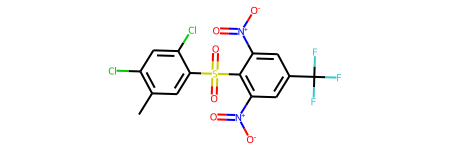

In [22]:
Chem.MolFromSmiles(active.SMILES[34])

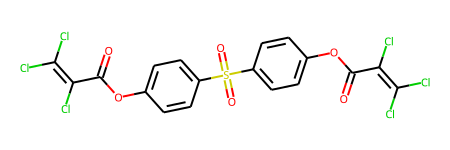

In [23]:
Chem.MolFromSmiles(active.SMILES[35])

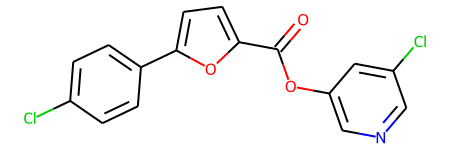

In [24]:
Chem.MolFromSmiles(active.SMILES[55])

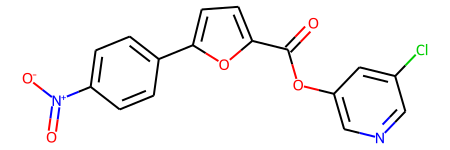

In [25]:
Chem.MolFromSmiles(active.SMILES[56])

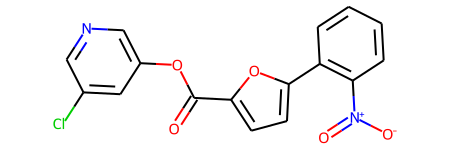

In [26]:
Chem.MolFromSmiles(active.SMILES[58])

In [27]:
cmpd_A = pcp.Compound.from_cid(2744814)
print(cmpd_A.molecular_formula)
print(cmpd_A.iupac_name)

C21H14Cl2N4OS2
N-(3,5-dichlorophenyl)-2-[4-(2-phenyl-1,3-thiazol-4-yl)pyrimidin-2-yl]sulfanylacetamide


In [10]:
# from rdkit.Chem import PandasTools
# from rdkit import RDConfig

# PandasTools.AddMoleculeColumnToFrame(active, smilesCol='SMILES', 
#                                      molCol='ROMol', 
#                                      includeFingerprints=False)

# active.head()